<h1>Predicting Bike Rentals using Machine Learning</h1>

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which I'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's <a href="http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">website.</a>

Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - Whether or not the day was a weekday
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In this project, I'll try to predict the total number of bikes people rented in a given hour. I'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, I'll create a few different machine learning models and evaluate their performance.


In [53]:
#import dependences
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
% matplotlib inline

In [3]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")

In [4]:
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


I am in luck, as most the columns are numerical, and will not require a change in datatype.
Lets look at the distribution of bike rentals by making a histogram of the cnt column

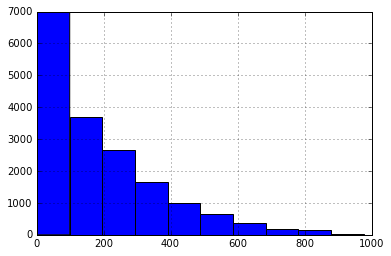

In [14]:
bike_rentals["cnt"].hist()

Lets make a correlation matrix, which I can then use to observe the correlation between each of my feature columns, and my target, cnt.

In [16]:
corr_matrix = bike_rentals.corr()

In [17]:
corr_matrix['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. I can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [19]:
def assign_label(hr):
    """Assign labels as follows:
    1: Morning
    2: Afternoon
    3: Evening
    4: Night"""
    if hr >=6 and hr <12:
        return 1
    elif hr >=12 and hr <18:
        return 2
    elif hr >=18 and hr <24:
        return 3
    else:
        return 4

In [20]:
bike_rentals["time_label"] = bike_rentals['hr'].apply(assign_label)

Before I can begin applying machine learning algorithms, I'll need to split the data into training and testing sets. This will enable me to train an algorithm using the training set, and evaluate its accuracy on the testing set. If I train an algorithm on the training data, then evaluate its performance on the same data, I can get an unrealistically low error value, due to overfitting.

I also need to chose an error metric by which I will evaluate my model with. The prediction I am trying to make here is a problem of regression rather than classification. My target column contains continuous data and I am trying to predict a value accuarately, rather than trying to categorise based on my features. I will therefore use Mean Squared Error which will provide me with the magnitude of error from my model. I can also take the root of this value to convert the units of the error value back to the units of my original target column (quantity of bikes rented).

In [21]:
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

Now that I've done some exploration and manipulation, I am ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that some of the columns are highly correlated with cnt.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

I'll need to ignore the casual and registered columns because cnt is derived from them. If I'mtrying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that I would already know casual or registered, because those numbers are added together to get cnt.

In [31]:
features = bike_rentals.columns.tolist()

In [33]:
columns_to_remove = ['dteday', 'casual', 'registered', 'cnt']
for c in columns_to_remove:
    features.remove(c)

In [37]:
target = 'cnt'

In [40]:
model = LinearRegression()
model.fit(train[features], train[target])
predictions = model.predict(test[features])
mse = mean_squared_error(test[target],predictions)
rmse = np.sqrt(mse)
print(rmse)

130.583784871


The error is very high. This might be a result of large outliers, for example there are a few very high rental counts, which skew the data. Large errors are penalised more with mean squared error, which leads to a higher overall error, so outliers have a heavy influence.

I shall try applying instead a decision tree to this problem. Then I shall compare the performance of both. 
Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [46]:
def create_df_model(min_samples_leaf=1):    
    dt_model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)
    dt_model.fit(train[features],train[target])
    dt_predictions = dt_model.predict(test[features])
    dt_mse = mean_squared_error(test[target], dt_predictions)
    dt_rmse = np.sqrt(dt_mse)
    print(dt_rmse)
create_df_model(1)

57.5819474092


Already we can see a significant reduction in error. I shall now experiment with parameters to try and reduce any overfitting. The 'min_samples_leaf' parameter defines the minimum number of samples to define a 'leaf'. By default this value is 1, so I shall try changing it and seeing the effect on the RMSE.

In [47]:
#min_samples_leaf = 2
create_df_model(2)

54.1425034624


In [48]:
#min_samples_leaf = 5
create_df_model(5)

52.3147086686


In [52]:
#min_samples_leaf = 10
create_df_model(10)

52.0097663572


As you can see, increasing 'min_samples_leaf' has diminishing returns, this is because as the complexity of the model decreases, the model becomes less likely to overfit, but more likely to hold bias.

I will now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [67]:
def create_rf_model(min_samples_leaf = 1):
    rf_model = RandomForestRegressor(min_samples_leaf=min_samples_leaf)
    rf_model.fit(train[features],train[target])
    rf_predictions = rf_model.predict(test[features])
    rf_mse = mean_squared_error(test[target], rf_predictions)
    rf_rmse = np.sqrt(rf_mse)
    print(rf_rmse)

In [68]:
create_rf_model()

45.939638312


In [69]:
create_rf_model(5)

46.6971780704


So, we can see that the random forest model performs better, with a reduction in RMSE. The random forest model reduces overfitting by sampling predictions from multiple decision trees.